# Abstrakt


# Cel projektu

Celem projektu było stworzenie liniowego modelu ilości wpadków na drogach z pomocą zmiennych objaśniających pobranych ze strony policji oraz na podstawie pogody.

# Dane

Dane pochodzą ze strony policji, obejmują zakres pierwszego kwartału roku 2020. Więcej o nich można znaleźć tutaj: [Strona policji](https://policja.pl/pol/form/1,dok.html)

Drugi zestaw danych to dane meteorologiczne dla Warszawy, również z pierwszego kwartału roku 2020. Pobrane zostały z pomocą API platrofmy www.meteostat.net/

## Pobranie danych

In [1]:
import pandas
import numpy as np

In [2]:
df = pandas.read_csv("./dane.csv", sep="\t", decimal=",", dtype="float32")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Wypadki drogowe                  60 non-null     float32
 1   Zatrzymani poszukiwani           60 non-null     float32
 2   Zatrzymani nietrzeźwi kierujący  60 non-null     float32
 3   temperature_max                  60 non-null     float32
 4   mobilność pojazdów               60 non-null     float32
 5   Zabici w wypadkach               60 non-null     float32
 6   Ranni w wypadkach                60 non-null     float32
 7   temperature                      60 non-null     float32
 8   temperature_min                  60 non-null     float32
 9   Interwencje                      60 non-null     float32
 10  Zatrzymani na gorącym uczynku    60 non-null     float32
dtypes: float32(11)
memory usage: 2.7 KB


Jak widać powyżej dane składają się z 60 próbek oraz nie posiadają pustych wartości.

## Eliminacja quasi - stalych

In [4]:
S = df.var()
x = df.mean()

In [5]:
S / x

Wypadki drogowe                      5.019958
Zatrzymani poszukiwani              16.410904
Zatrzymani nietrzeźwi kierujący     13.943410
temperature_max                      1.059987
mobilność pojazdów                 -13.597410
Zabici w wypadkach                   1.414983
Ranni w wypadkach                    6.134233
temperature                          1.120702
temperature_min                      2.801074
Interwencje                        234.719513
Zatrzymani na gorącym uczynku       24.527481
dtype: float32

Ze względu na małą zmienność (5%) wartości przewydywanej (wypadki drogowe). W modelu uwzględnię wszystkie zmienne, kóre mają zmienność większą.

In [6]:
df = df[df.columns[np.abs((S / x)) > 5]]

In [7]:
df.head(5)

,Wypadki drogowe,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,mobilność pojazdów,Ranni w wypadkach,Interwencje,Zatrzymani na gorącym uczynku
0,31.0,126.0,106.0,-62.619999,30.0,11688.0,255.0
1,17.0,139.0,104.0,-63.669998,27.0,13228.0,301.0
2,29.0,151.0,94.0,-64.220001,32.0,13966.0,296.0
3,24.0,153.0,114.0,-63.400002,20.0,15926.0,285.0
4,30.0,151.0,145.0,-70.489998,33.0,18900.0,383.0


# Wybór zmiennych do modelu

Wybierając zmienne w modelu, posłużę się metodą analizy macierzy współczynników korelacji.

In [8]:
from scipy.stats import t

alpha = 0.05
N = len(df)
t = t.ppf(1 - alpha, N-2)

In [9]:
r = np.sqrt(t**2/(t**2 + N - 2))
r

0.2143825406137366

In [10]:
df.corr()

,Wypadki drogowe,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,mobilność pojazdów,Ranni w wypadkach,Interwencje,Zatrzymani na gorącym uczynku
Wypadki drogowe,1.000000,0.507234,0.429340,0.767076,0.960340,0.379193,0.690641
Zatrzymani poszukiwani,0.507234,1.000000,-0.134454,0.723037,0.492617,0.192777,0.462056
Zatrzymani nietrzeźwi kierujący,0.429340,-0.134454,1.000000,0.401068,0.415218,0.120871,0.750261
mobilność pojazdów,0.767076,0.723037,0.401068,1.000000,0.751973,0.086337,0.831563
Ranni w wypadkach,0.960340,0.492617,0.415218,0.751973,1.000000,0.292307,0.680938
Interwencje,0.379193,0.192777,0.120871,0.086337,0.292307,1.000000,0.154223
Zatrzymani na gorącym uczynku,0.690641,0.462056,0.750261,0.831563,0.680938,0.154223,1.000000


1. Usuwam zmienne, dla których wartość w kolumnie `Wypadki drogowe` jest poniżej progu `r` (tutaj wszystkie są OK).

In [11]:
df.corr().loc["Ranni w wypadkach"]

Wypadki drogowe                    0.960340
Zatrzymani poszukiwani             0.492617
Zatrzymani nietrzeźwi kierujący    0.415218
mobilność pojazdów                 0.751973
Ranni w wypadkach                  1.000000
Interwencje                        0.292307
Zatrzymani na gorącym uczynku      0.680938
Name: Ranni w wypadkach, dtype: float64

2. Wybieram `Ranni w wypadkach`. Usuwam `Zatrzymani poszukiwani`, `Zatrzymani nietrzeźwi kierujący`, `mobilność pojazdów`, `Interwencje` ,`Zatrzymani na gorącym uczynku`, 
3. Koniec.

# Budowa modelu
## Model 1

In [12]:
import statsmodels.api as sm

y = df['Wypadki drogowe']
X = df[['Ranni w wypadkach']]
X = sm.add_constant(X) # Dodaję stałą do modelu

In [13]:
model = sm.OLS(y, X)

In [14]:
results = model.fit()
print(results.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.921   
Dependent Variable: Wypadki drogowe  AIC:                345.3008
Date:               2022-01-02 20:21 BIC:                349.4895
No. Observations:   60               Log-Likelihood:     -170.65 
Df Model:           1                F-statistic:        688.0   
Df Residuals:       58               Prob (F-statistic): 7.33e-34
R-squared:          0.922            Scale:              17.892  
-----------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|  [0.025 0.975]
-----------------------------------------------------------------
const                3.6426   1.6710  2.1798 0.0333 0.2976 6.9875
Ranni w wypadkach    0.8211   0.0313 26.2298 0.0000 0.7584 0.8838
-----------------------------------------------------------------
Omnibus:               5.317        Durbin-Watson:          1.687
Prob(Omnibus):         0.07

Model ma:
- [x] R-squared powyżej 0.8
- [x] Adj. R-squared powyżej 0.8
- [x] Prob (F-statistic) < 0.05
- [x] p value dla każdej ze zmiennych < 0.05
- [x] Prob(Omnibus) > 0.05 (test normalności reszt, H_0: rozkład normalny)
- [x] Prob(JB) > 0.05

Zatem model przeszedł wszystkie testy statystyczne.

### Analiza reszt

In [15]:
import seaborn as sns

Text(0.5, 1.0, 'Histogram reszt modelu')

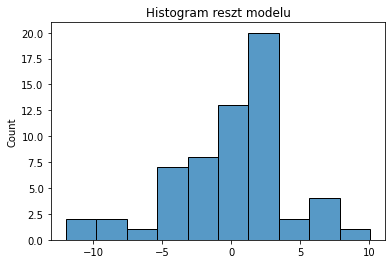

In [16]:
sns.histplot(results.resid).set_title('Histogram reszt modelu')

Jak widać na wykresie, reszty te przypominają rozkład normalny, ale cechują się przechyleniem w prawo.

**Test normalności rozkładu reszt**

In [21]:
# Test normalności rozkładu rest
from scipy.stats import normaltest
print("Pvalue:", normaltest(results.resid).pvalue)

Pvalue: 0.0700463215582532


Aby sprawdzić czy reszty mają rozkład normalny skorzystałem z funkcji normaltest. Więcej o niej można poczytac pod adresem: [dokumentacja scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html). Opiera się on na testach D’Agostino oraz Pearsona, gdzie $H_o$ - próbki pochodzą z rozkładu normalnego. Pvalue jest większe od 0.05 zatem mam **brak podstaw do odrzucenia $H_o$.**

**Test serii**

In [22]:
# Test serii
from statsmodels.sandbox.stats.runs import runstest_1samp 
z_statistic, pvalue = runstest_1samp(results.resid)
print("Test serii")
print(f"Wartość statystyki: {z_statistic}")
print(f"Pvalue : {pvalue}")

Test serii
Wartość statystyki: -0.38897672411182915
Pvalue : 0.697293364649107


Pvalue jest > 0.05 zatem **brak podstaw do odrzucenia $H_o$.**

**Test skośności**

In [34]:
from scipy.stats import skewtest
skewtest(a=results.resid)

SkewtestResult(statistic=-1.8481640002989976, pvalue=0.06457862153466662)

$H_o$ tego testu jest taka iż skośność jest taka sama jak w rozkładzie normalnym
Pvalue jest większe niż 0.05 **zatem brak podstaw do odrzucenia $H_o$**.

**Test kurtozy reszt**

In [39]:
from scipy.stats import kurtosistest
kurtosistest(results.resid)

KurtosistestResult(statistic=1.3789441128898536, pvalue=0.16791198576635435)

$H_o$ tego testu jest taka iż kurtoza jest taka sama jak w rozkładzie normalnym
Pvalue jest większe niż 0.05 **zatem brak podstaw do odrzucenia $H_o$**.

**Statystyka Durbina-Watsona**

In [40]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(results.resid)

1.687491750620559

In [41]:
len(results.resid)

60

Z tablic dla $n=60$ oraz $k=1$ odczytałem obszar przyjęcia na $[1.549; 1.616]$ ([link do tablic](https://www3.nd.edu/~wevans1/econ30331/Durbin_Watson_tables.pdf)). Wartość statystyki leży poza przedziałem, zatem $H_o$ o **braku autokorelacji reszt należy odrzucić.**

### Wykresy 

In [47]:
import matplotlib.pylab as plt

Text(0.5, 1.0, 'Wykres przewidywań modelu')

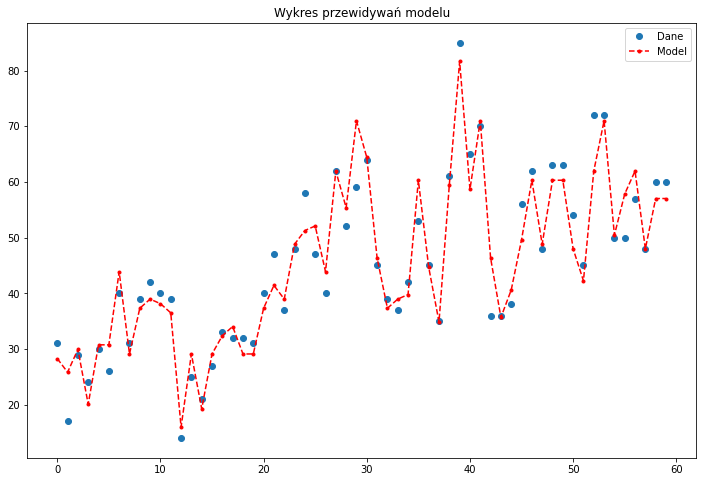

In [54]:
pred_ols = results.get_prediction()
x = df.index
y_true = df['Wypadki drogowe']
y = df['Ranni w wypadkach'] * 0.8211 + 3.6426

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(y_true, "o", label="Dane")
ax.plot(y, "r--.", label="Model")
ax.legend(loc="best")
ax.set_title("Wykres przewidywań modelu")

## Model 2

Pierwszy model jest ok, ale z czystej ciekwości sprawdziłem co stanie sie jeżeli nie usuniemy kolumny `Interwencje`, gdyż posiadała ona najmniejszą korelację (0.292307) z `Ranni w wypadku`. 

In [55]:
df.columns

Index(['Wypadki drogowe', 'Zatrzymani poszukiwani',
       'Zatrzymani nietrzeźwi kierujący', 'mobilność pojazdów',
       'Ranni w wypadkach', 'Interwencje', 'Zatrzymani na gorącym uczynku'],
      dtype='object')

In [56]:
y = df['Wypadki drogowe']
X = df[['Ranni w wypadkach', 'Interwencje']]
X = sm.add_constant(X) # Dodaję stałą do modelu
model = sm.OLS(y, X) # Tworzę model
results = model.fit() # Dopasowanie parametrów
print(results.summary2()) # Wyniki

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.931   
Dependent Variable: Wypadki drogowe  AIC:                338.5026
Date:               2021-12-30 15:50 BIC:                344.7856
No. Observations:   60               Log-Likelihood:     -166.25 
Df Model:           2                F-statistic:        396.0   
Df Residuals:       57               Prob (F-statistic): 3.71e-34
R-squared:          0.933            Scale:              15.723  
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
const             -8.3224   4.2844 -1.9425 0.0570 -16.9018 0.2571
Ranni w wypadkach  0.7942   0.0307 25.8817 0.0000   0.7327 0.8556
Interwencje        0.0008   0.0003  3.0004 0.0040   0.0003 0.0014
-----------------------------------------------------------------
Omnibus:              1.994

Model ma:
- [x] R-squared powyżej 0.8
- [x] Adj. R-squared powyżej 0.8
- [x] Prob (F-statistic) < 0.05
- [ ] p value dla każdej ze zmiennych $\nless$ 0.05 (pvalue dla const = 0.057)
- [x] Prob(Omnibus) > 0.05 (test normalności reszt, H_0: rozkład normalny)
- [x] Prob(JB) > 0.05

Zatem model nie przeszedł jednego z testów, znajduje się dokładnie na granicy decyzji. Poprawił się natomiast wynik dla pozostałych tesów (Omnibus i JP).

### Analiza reszt modelu
Z analizy OLS wiemy już, że nie mamy podstaw do odrzucenia hipotezy, że reszty mają rozkład normalny. Sprawdzę to jeszcze testem serii.

Text(0.5, 1.0, 'Histogram reszt modelu')

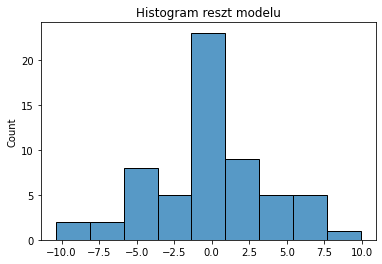

In [57]:
sns.histplot(results.resid).set_title('Histogram reszt modelu')

In [58]:
# Test serii
from statsmodels.sandbox.stats.runs import runstest_1samp 
z_statistic, pvalue = runstest_1samp(results.resid)
print("Test serii")
print(f"Wartość statystyki: {z_statistic}")
print(f"Pvalue : {pvalue}")

Test serii
Wartość statystyki: -2.0579037471170873
Pvalue : 0.039599373980042735


pvalue < 0.05 . Zatem hipotezę o normalności reszt należy odrzucić.

Text(0.5, 1.0, 'Wykres przewidywań modelu')

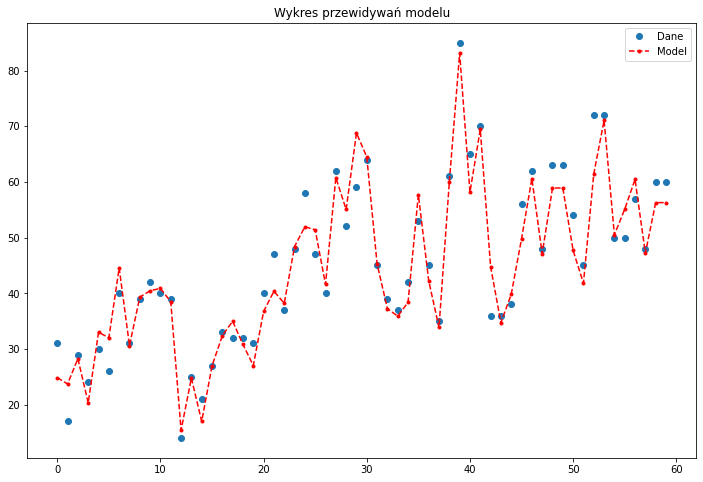

In [59]:
pred_ols = results.get_prediction()
x = df.index
y_true = df['Wypadki drogowe']
y = df['Ranni w wypadkach'] * 0.7942 - 8.3224 + df['Interwencje'] * 0.0008

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(y_true, "o", label="Dane")
ax.plot(y, "r--.", label="Model")
ax.legend(loc="best")
ax.set_title("Wykres przewidywań modelu")

Model ten sprawuje się gorzej, szczególnie w ostatnich próbkach można zauważyć dłuższe okresy niedoszacowania i przeszacowania przez model. Na poniższym wykresie przedstawiłem jak wyglądają kolejne serie.

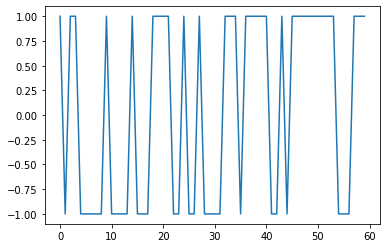

In [36]:
plt.plot(np.sign(results.resid))

# Podsumowanie
